# Mastering Image Classification: An All-Inclusive Tutorial on CNNs and Machine Learning Workflows
### by Moreno Gallo, gallomor@students.zhaw.ch

## Motivation / Background
##### The interest in machine learning projects is steadily increasing as the technology finds applications in various fields. However, it is very time-consuming, challenging, and complex to gather all the necessary information to get started. Beginning with data scraping, it can be particularly difficult to find suitable sources and understand the intricacies of the scraping process.

## Addressed Problem
##### The specific problem I am trying to solve is the provision of a complete and easily understandable machine learning project for image classification that covers all essential steps from start to finish. Traditional resources and tutorials are often fragmented and only cover isolated aspects of the entire process, making it difficult for beginners to develop a comprehensive understanding. This project aims to overcome these hurdles by offering a complete guide that encompasses the entire workflow: from web scraping for data collection, through the division of data into training, validation, and test sets, data preparation, the programming and training of a CNN model, to prediction and evaluation using various metrics. This enables users to modify the project according to their needs through simple adjustments of the variable's value.

## Relevance
##### My project is relevant because it provides a comprehensive introduction to the complex world of machine learning and lowers the barriers to accessing image classification technology. In an era where visual data is generated on a massive scale, the ability to efficiently and accurately classify these data is invaluable. This project enables users to learn the fundamental techniques and best practices necessary to develop successful machine learning models. It offers not only theoretical knowledge but also practical application opportunities by covering all steps of the process from A to Z. This makes it easier to apply the acquired knowledge to real-world problems and develop innovative solutions.

## Installing packages from the 'requirements.txt' file:
##### Prompt: pip install -r requirements.txt

## Imports
##### In the first part, all necessary imports for the project are included. Imports are essential components in programming that allow us to include external libraries and modules, providing additional functionality and tools that are crucial for efficiently developing and running our machine learning project. These libraries include packages for scraping, data manipulation, model building, and performance evaluation.

In [47]:

import requests
from bs4 import BeautifulSoup
import time
import logging
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import shutil
import random
from PIL import Image
import numpy as np
from keras.preprocessing import image
from IPython.display import display, Markdown
from tensorflow.keras.preprocessing import image
import pandas as pd
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import label_binarize
from tensorflow.keras.preprocessing import image_dataset_from_directory
import seaborn as sns
import itertools


## Web Scraper for unsplash.com
##### The Python script automates the process of scraping images from the Unsplash website based on user-defined search terms. Users are prompted to enter folder names and corresponding search keywords, after which the script creates separate directories for each folder and downloads the relevant images into them. It uses the BeautifulSoup library to extract image URLs from the web pages and the Requests module to manage HTTP requests, including error handling and implementing pauses to adhere to rate limits. This design choice was intentionally made to simplify the entry into web scraping for beginners, as scraping can be complex and intimidating; by providing a ready-to-use code structure, users can apply it to their projects by merely specifying the search terms, thus facilitating an accessible introduction to the concept of web scraping.
##### During the project, I observed that the images from Unsplash exhibited limited variation, which proved insufficient to address image classification challenges such as viewpoint variation, illumination conditions, scale variations, and intra-class variation; consequently, I incorporated two additional Kaggle datasets to train the model on a larger pool of images with minimal similarity.
* Web scraped unsplash.com for folders: food, people, vehicles
* [Kaggle Vehicle Classification Dataset](https://www.kaggle.com/datasets/marquis03/vehicle-classification?select=train) - added to the scraped unsplash.com images
* [Kaggle Intel Image Classification Dataset](https://www.kaggle.com/datasets/puneet6060/intel-image-classification)


In [ ]:
import os
import requests
from bs4 import BeautifulSoup
import logging
import time

def scrape_unsplash_images(search_terms, folder_name):
    # Set up logging
    log_file_path = os.path.join(os.getcwd(), 'unsplash_scraper.log')
    logging.basicConfig(filename=log_file_path, level=logging.INFO)

    # Base URL for Unsplash search
    base_url = "https://unsplash.com/s/photos/{}"

    # Create directory to save images
    save_dir = f"dataset/all_images/{folder_name}"
    os.makedirs(save_dir, exist_ok=True)

    # Variable to keep track of overall image number across all terms
    image_number = 1

    for term in search_terms:
        # Construct search URL
        search_url = base_url.format(term)

        # Extract image URLs with error handling
        image_urls = []
        try:
            response = requests.get(search_url)
            response.raise_for_status()  # Raise an exception for non-200 status codes
            soup = BeautifulSoup(response.text, 'html.parser')
            for img in soup.find_all('img'):
                if img.has_attr('src') and img['src'].startswith('https://images.unsplash.com/photo'):
                    image_urls.append(img['src'])
        except requests.exceptions.RequestException as e:
            logging.error(f"Error fetching images for {term}: {e}")
            continue

        # Download images
        for url in image_urls:
            response = requests.get(url)
            response.raise_for_status()  # Korrektur: Prüfung auf erfolgreiche Antwort

            # Extract image format from response headers
            image_format = response.headers.get('Content-Type').split('/')[1]
            image_name = f"{folder_name}_{image_number}.{image_format}"
            image_path = os.path.join(save_dir, image_name)

            with open(image_path, 'wb') as f:
                f.write(response.content)

            logging.info(f"Downloaded image {image_number}: {image_name}")
            image_number += 1  # Increment the overall image count

            # Delay to avoid rate limiting
            time.sleep(1)  # Adjust delay as needed



def main():
    folder_search_pairs = {}
    num_folders = int(input("How many folder names do you want to enter? "))
    for _ in range(num_folders):
        folder_name = input("Enter a folder name: ").strip().replace(' ', '_').lower()
        search_terms = input(f"Enter search terms for {folder_name}, separated by commas: ").split(',')
        folder_search_pairs[folder_name] = search_terms

    for folder_name, search_terms in folder_search_pairs.items():
        scrape_unsplash_images(search_terms, folder_name)

if __name__ == "__main__":
    main()


## Split Dataset
##### This code splits images from the source directory 'dataset/all_images' into training, validation, and test sets, while preserving the original category subdirectories. It ensures the existence of destination directories, shuffles the images to guarantee random selection, and allocates them to the respective directories based on the specified 70-20-10 ratio for the training, validation, and test datasets. The function creates subdirectories if they do not already exist and distributes the images accordingly. The user does not need to modify this code for it to execute correctly. A 70-20-10 split for training, validation, and test datasets in machine learning projects is employed to ensure that the model is trained on the majority of the data, validated on a separate subset to tune hyperparameters and prevent overfitting, and tested on an unseen subset to evaluate its generalization performance.

In [8]:

import os
import shutil
import random

def split_dataset(source_dir, train_dir, validation_dir, test_dir, train_ratio=0.7, validation_ratio=0.2, test_ratio=0.1):
    """
    Splits images from source_dir into train, validation, and test directories.
    Maintains category subdirectories.
    """
    # Ensure destination directories exist
    for dir_path in [train_dir, validation_dir, test_dir]:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
    
    categories = os.listdir(source_dir)
    
    for category in categories:
        category_path = os.path.join(source_dir, category)
        
        # Skip if it's not a directory (such as .DS_Store files)
        if not os.path.isdir(category_path):
            continue
        
        images = os.listdir(category_path)
        
        # Shuffle images to ensure random selection
        random.shuffle(images)
        
        # Split indices for the three sets
        train_split = int(len(images) * train_ratio)
        validation_split = train_split + int(len(images) * validation_ratio)
        
        train_images = images[:train_split]
        validation_images = images[train_split:validation_split]
        test_images = images[validation_split:]
        
        # Create destination subdirectories if they don't exist
        dest_train_path = os.path.join(train_dir, category)
        dest_validation_path = os.path.join(validation_dir, category)
        dest_test_path = os.path.join(test_dir, category)
        
        os.makedirs(dest_train_path, exist_ok=True)
        os.makedirs(dest_validation_path, exist_ok=True)
        os.makedirs(dest_test_path, exist_ok=True)
        
        # Move images to train set
        for image in train_images:
            src_path = os.path.join(category_path, image)
            dest_path = os.path.join(dest_train_path, image)
            shutil.move(src_path, dest_path)
            #print(f"Moved {src_path} to {dest_path}")
        
        # Move images to validation set
        for image in validation_images:
            src_path = os.path.join(category_path, image)
            dest_path = os.path.join(dest_validation_path, image)
            shutil.move(src_path, dest_path)
            #print(f"Moved {src_path} to {dest_path}")
        
        # Move images to test set
        for image in test_images:
            src_path = os.path.join(category_path, image)
            dest_path = os.path.join(dest_test_path, image)
            shutil.move(src_path, dest_path)
            #print(f"Moved {src_path} to {dest_path}")

# Paths
source_dir = 'dataset/all_images'
train_dir = 'dataset/train'
validation_dir = 'dataset/validation'
test_dir = 'dataset/test'

# Perform the split
split_dataset(source_dir, train_dir, validation_dir, test_dir)



## Verifying Dataset Split Ration
##### This code defines a function to enumerate the number of images within a directory and its subdirectories. Subsequently, it utilizes this function to quantify the images in the training, validation, and test directories, and prints the respective counts. This procedure serves to verify that the dataset has been successfully split into the specified 70-20-10 ratios.

In [41]:
import os

def count_images_in_directory(directory):
    """
    Counts the number of images in a directory and its subdirectories.
    """
    total_images = 0
    for root, dirs, files in os.walk(directory):
        total_images += len(files)
    return total_images

# Paths
train_dir = 'dataset/train'
validation_dir = 'dataset/validation'
test_dir = 'dataset/test'

# Count images
train_image_count = count_images_in_directory(train_dir)
validation_image_count = count_images_in_directory(validation_dir)
test_image_count = count_images_in_directory(test_dir)

print(f"Number of images in train directory: {train_image_count}")
print(f"Number of images in validation directory: {validation_image_count}")
print(f"Number of images in test directory: {test_image_count}")


Number of images in train directory: 9575
Number of images in validation directory: 2734
Number of images in test directory: 1375


## Data Preparation
##### This code initializes and preprocesses the datasets for training and validation of a machine learning model. It loads images from the specified directories, resizes and rescales them, and applies data augmentation techniques to enhance the robustness of the model. This preprocessing step is crucial as it ensures the data is properly formatted and augmented, which improves the model's ability to generalize from the training data to new, unseen data.

In [48]:

imageSize = 150
batchSize = 42
EPOCHS = 30

train_dataset = tf.keras.preprocessing.image_dataset_from_directory("dataset/train", shuffle=True, image_size = (imageSize,imageSize),batch_size = batchSize)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory("dataset/validation", shuffle=True, image_size = (imageSize,imageSize),batch_size = batchSize)

class_names = train_dataset.class_names
#print("class_names: " + str(class_names))

train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

resize_rescale = tf.keras.Sequential([
    layers.Resizing(imageSize, imageSize),
    layers.Rescaling(1.0 / 255)
])

# layer for data augmentation
dataAugmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])


input_shape = (batchSize, imageSize, imageSize, 3)
numClasses = len(class_names)




Found 9575 files belonging to 7 classes.
Found 2734 files belonging to 7 classes.


## Define CNN Model
##### This code defines a Convolutional Neural Network (CNN) model using the TensorFlow Keras API. The model architecture comprises several convolutional layers followed by max-pooling layers to extract features from images. These features are then flattened and passed through dense layers for classification. The 'resize_rescale' and 'dataAugmentation' layers preprocess the input images, thereby enhancing the model's generalization capability. This model is significant as it is designed to effectively learn patterns and features from the image data, enabling accurate image classification.

In [49]:

model = models.Sequential([
    resize_rescale,
    dataAugmentation,
    layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(numClasses, activation='softmax')
    
])

model.build(input_shape = input_shape)

print(model.summary())


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_28 (Sequential)      │ (42, 150, 150, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_29 (Sequential)      │ (42, 150, 150, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (42, 148, 148, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (42, 74, 74, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (42, 72, 72, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (42, 36, 36, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (42, 34, 34, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (42, 17, 17, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (42, 15, 15, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (42, 7, 7, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (42, 5, 5, 256)        │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (42, 2, 2, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (42, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (42, 256)              │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (42, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (42, 7)                │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 656,807 (2.51 MB)

 Trainable params: 656,807 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

None


## Compile & Train Model
##### This code compiles a Convolutional Neural Network (CNN) model using the Adam optimizer with a specified learning rate of 0.0001, the sparse categorical cross-entropy loss function, and accuracy as a performance metric. It subsequently trains the model on the training dataset for a predefined number of epochs, validating it on a separate validation dataset while recording the training history. The accuracy and loss values for both training and validation sets are extracted and plotted to visualize the model's performance. Finally, the trained model is saved for future use. This process is essential for evaluating and enhancing the model's predictive capabilities.

Epoch 1/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 29s 110ms/step - accuracy: 0.3430 - loss: 1.6503 - val_accuracy: 0.5256 - val_loss: 1.2471
Epoch 2/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 24s 107ms/step - accuracy: 0.5388 - loss: 1.2039 - val_accuracy: 0.5775 - val_loss: 1.1600
Epoch 3/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.5732 - loss: 1.0974 - val_accuracy: 0.6097 - val_loss: 1.0759
Epoch 4/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.6394 - loss: 0.9585 - val_accuracy: 0.6426 - val_loss: 0.9942
Epoch 5/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.6500 - loss: 0.9250 - val_accuracy: 0.6350 - val_loss: 1.0461
Epoch 6/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.6666 - loss: 0.9043 - val_accuracy: 0.6291 - val_loss: 1.0246
Epoch 7/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.7010 - loss: 0.8254 - val_accuracy: 0.7315 - val_loss: 0.7481
Epoch 8/30
228/228 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.7200 - loss: 0

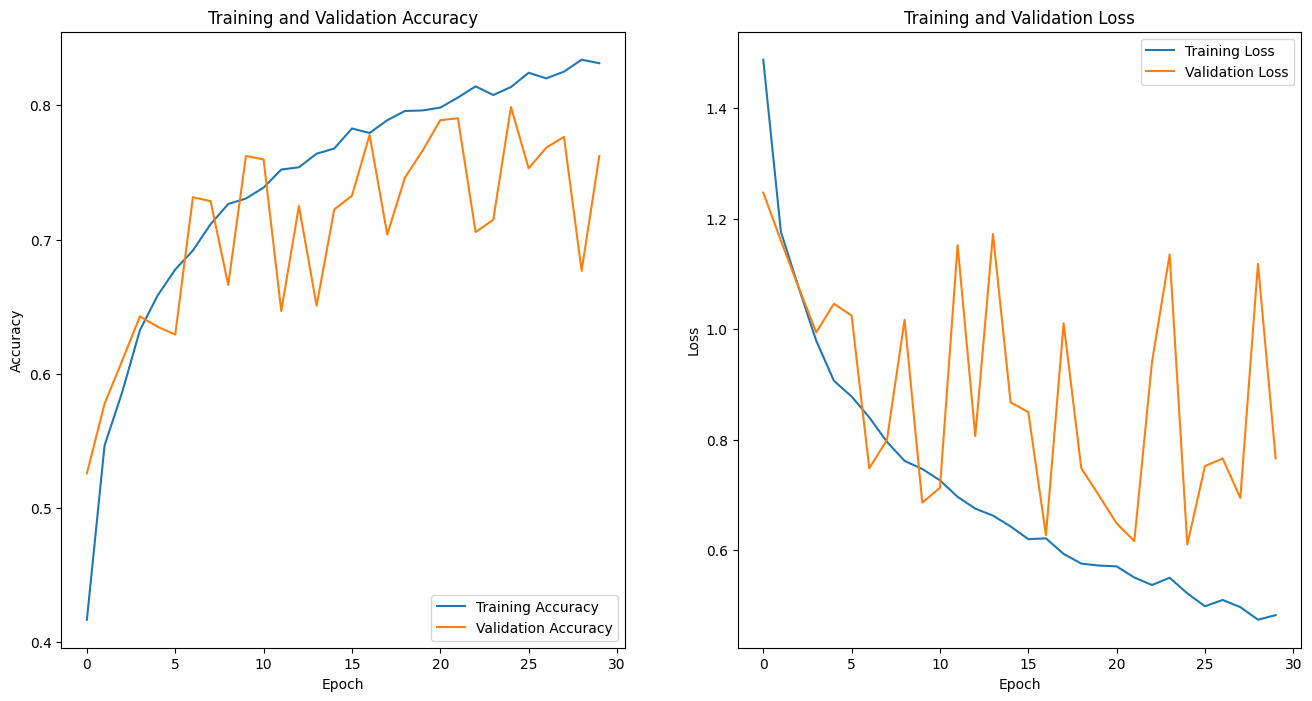

    Epoch  Accuracy  Validation Accuracy      Loss  Validation Loss
0       1  0.416501             0.525604  1.487732         1.247095
1       2  0.546423             0.577542  1.175959         1.160005
2       3  0.586214             0.609729  1.075598         1.075943
3       4  0.632376             0.642648  0.979010         0.994186
4       5  0.658172             0.634967  0.906576         1.046145
5       6  0.677598             0.629115  0.878135         1.024637
6       7  0.691802             0.731529  0.840367         0.748118
7       8  0.711436             0.728603  0.796157         0.799644
8       9  0.726475             0.666057  0.761596         1.017320
9      10  0.730548             0.762253  0.747044         0.686088
10     11  0.738694             0.759693  0.726426         0.713000
11     12  0.752167             0.646672  0.696576         1.152008
12     13  0.753838             0.724945  0.675245         0.806602
13     14  0.763969             0.650695  0.6626

In [50]:

# compile
model.compile(
    optimizer="adam",
    #optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# train
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    batch_size=batchSize,
    verbose=1,
    validation_data=validation_dataset
)

# Metrikwerte sammeln
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Grafiken erstellen
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

# Tabelle der Kennwerte erstellen
results_df = pd.DataFrame({
    'Epoch': range(1, EPOCHS + 1),
    'Accuracy': acc,
    'Validation Accuracy': val_acc,
    'Loss': loss,
    'Validation Loss': val_loss
})

# Tabelle anzeigen
print(results_df)

# Modell speichern
model.save("models/ImageClassificationCNN.keras")


## Test the Model and predict a class
##### This script establishes an environment for displaying images inline in the Jupyter Notebook, loads the CNN model, and prepares the data for making predictions. It defines a function to preprocess images, generate predictions using the loaded model, and subsequently return the predicted class along with the confidence level. The script then loads a test image, converts it to the appropriate format, executes the prediction function, and displays the predicted class and confidence. Finally, it resizes the original image and displays it alongside the prediction results.
##### To test the model, you can specify a path in the variable 'img_path' and run this code block.

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_28 (Sequential)      │ (42, 150, 150, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_29 (Sequential)      │ (42, 150, 150, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (42, 148, 148, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (42, 74, 74, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (42, 72, 72, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (42, 36, 36, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (42, 34, 34, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (42, 17, 17, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (42, 15, 15, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (42, 7, 7, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (42, 5, 5, 256)        │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (42, 2, 2, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_10 (Flatten)            │ (42, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (42, 256)              │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (42, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (42, 7)                │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,970,423 (7.52 MB)

 Trainable params: 656,807 (2.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,313,616 (5.01 MB)

Found 9575 files belonging to 7 classes.


**Class Names:** ['cities', 'food', 'forest', 'mountain', 'people', 'sea', 'vehicles']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


**Predicted Class:** food

**Confidence:** 98.86%

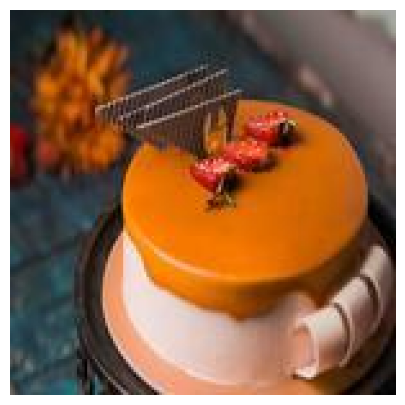

In [51]:

# Settings to display images inline in Jupyter Notebook
%matplotlib inline

imageSize = 128
batchSize = 32
CHANNELS = 3

# Load model
model = tf.keras.models.load_model('models/ImageClassificationCNN.keras')
model.summary()

train_dataset = tf.keras.preprocessing.image_dataset_from_directory("dataset/train", shuffle=True, image_size=(imageSize, imageSize), batch_size=batchSize)
class_names = train_dataset.class_names
display(Markdown(f"**Class Names:** {class_names}"))

def predictImage(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    resultIndex = np.argmax(predictions[0])
    predictedClass = class_names[resultIndex]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predictedClass, confidence

# Enter the image path here
img_path = "dataset/test/food/food12.jpeg"


originalImage = cv2.imread(img_path)
originalImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

testImage = image.load_img(img_path, target_size=(imageSize, imageSize))
testImage = image.img_to_array(testImage)

# Run predict function
predictedClassName, confidence = predictImage(model, testImage)
display(Markdown(f"**Predicted Class:** {predictedClassName}"))
display(Markdown(f"**Confidence:** {confidence}%"))

# Show result with image
scalePercentage = 300
width = int(originalImage.shape[1] * scalePercentage / 100)
height = int(originalImage.shape[0] * scalePercentage / 100)
resized = cv2.resize(originalImage, (width, height), interpolation=cv2.INTER_AREA)

plt.figure(figsize=(10, 5))
plt.imshow(resized)
plt.axis('off')  # Turn off axis
plt.show()



## Evaluation
##### The provided code evaluates the CNN by calculating key performance metrics, including accuracy, precision, recall, F1-score, and loss. It employs receiver operating characteristic (ROC) curves and area under the curve (AUC) metrics to assess the model's discriminative ability across different classes. Additionally, a confusion matrix is visualized to present the relationship between actual and predicted labels. The code offers a comprehensive performance analysis, aiding in the identification of the model's strengths and areas needing improvement before deployment.

Found 1375 files belonging to 7 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━

2024-06-07 13:39:01.429929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


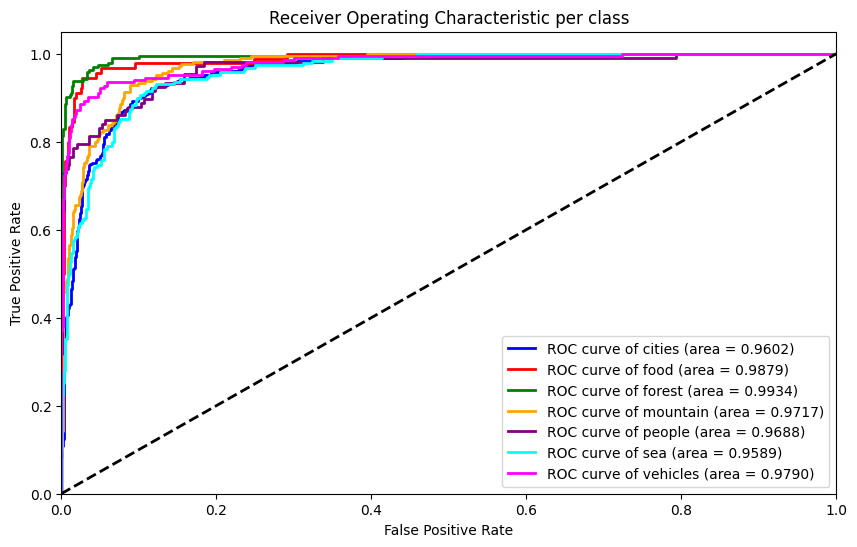

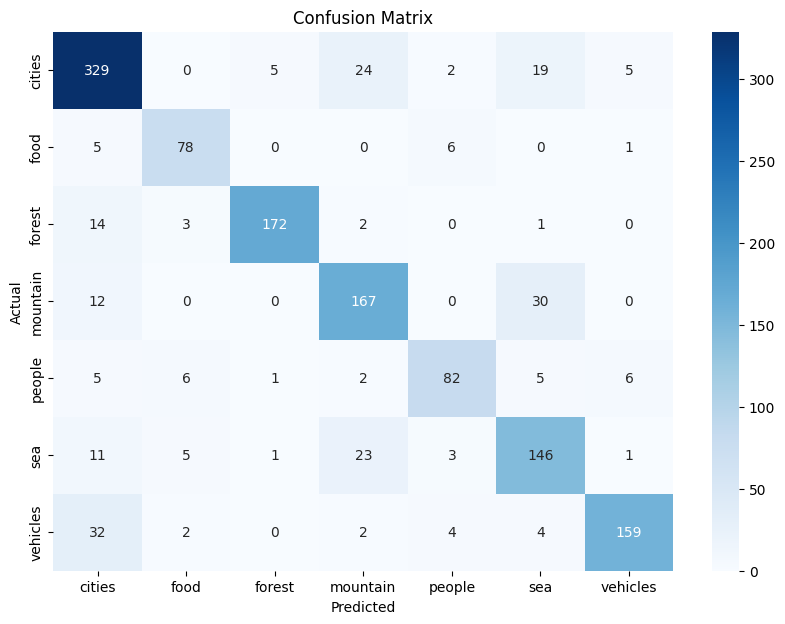

Accuracy: 0.8240
Precision: 0.8297
Recall: 0.8240
F1-Score: 0.8252
Loss: 0.5230

ROC AUC for each class:
cities: 0.9602
food: 0.9879
forest: 0.9934
mountain: 0.9717
people: 0.9688
sea: 0.9589
vehicles: 0.9790

Metric Evaluations:
Accuracy: 0.8240 - Very good accuracy.
Precision: 0.8297 - Very good precision.
Recall: 0.8240 - Very good recall.
F1-Score: 0.8252 - Very good F1-score.
Overall, very good accuracy.


In [53]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import itertools
import seaborn as sns

# Constants
imageSize = 224  # Replace with your model's input size
batchSize = 32  # Replace with your desired batch size
#class_names = ["Class1", "Class2", "Class3", "Class4", "Class5", "Class6", "Class7"]  # Replace with your actual class names
n_classes = len(class_names)  # Number of classes

# Load model
model = tf.keras.models.load_model("models/ImageClassificationCNN.keras")

# Load dataset
evaluation_dataset = image_dataset_from_directory(
    "dataset/test/",
    image_size=(imageSize, imageSize),
    batch_size=batchSize,
    label_mode='int'
)

# Collect predictions and true labels
y_pred = []
y_true = []
for images, labels in evaluation_dataset:
    preds = model.predict(images)
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

# Convert predictions to class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_array = np.array(y_true)

# Convert true labels to binary form for ROC AUC
y_true_binarized = label_binarize(y_true_array, classes=np.arange(n_classes))

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], np.array(y_pred)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 6))
colors = itertools.cycle(['blue', 'red', 'green', 'orange', 'purple', 'cyan', 'magenta'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of {class_names[i]} (area = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic per class')
plt.legend(loc="lower right")
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_true_array, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Accuracy, Precision, Recall, F1-Score and Loss
accuracy = accuracy_score(y_true_array, y_pred_classes)
report = classification_report(y_true_array, y_pred_classes, target_names=class_names, output_dict=True, zero_division=1)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_scores = report['weighted avg']['f1-score']

# Convert y_true_array and y_pred to tensors
y_true_tensor = tf.convert_to_tensor(y_true_array, dtype=tf.int32)
y_pred_tensor = tf.convert_to_tensor(y_pred, dtype=tf.float32)
loss = tf.keras.losses.SparseCategoricalCrossentropy()(y_true_tensor, y_pred_tensor).numpy()

# Print metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_scores:.4f}")
print(f"Loss: {loss:.4f}")

# Print ROC AUC for each class
print("\nROC AUC for each class:")
for i in range(n_classes):
    print(f"{class_names[i]}: {roc_auc[i]:.4f}")

# Evaluation of metrics
def evaluate_metric(value, name):
    if value > 0.9:
        comment = f"Excellent {name}."
    elif value > 0.8:
        comment = f"Very good {name}."
    elif value > 0.7:
        comment = f"Good {name}, but there is room for improvement."
    else:
        comment = f"The {name} needs improvement."
    return comment

print("\nMetric Evaluations:")
print(f"Accuracy: {accuracy:.4f} - {evaluate_metric(accuracy, 'accuracy')}")
print(f"Precision: {precision:.4f} - {evaluate_metric(precision, 'precision')}")
print(f"Recall: {recall:.4f} - {evaluate_metric(recall, 'recall')}")
print(f"F1-Score: {f1_scores:.4f} - {evaluate_metric(f1_scores, 'F1-score')}")

# Performance comments
if accuracy > 0.9:
    print("Overall, excellent accuracy.")
elif accuracy > 0.8:
    print("Overall, very good accuracy.")
elif accuracy > 0.7:
    print("Overall, good accuracy.")
else:
    print("Overall, the accuracy needs improvement.")


## Interpretation
##### The performance metrics for the CNN image classification project suggest that the model is performing well. With an accuracy of 0.8240, precision of 0.8297, recall of 0.8240, and F1-score of 0.8252, the model demonstrates reliable performance across various evaluation measures, maintaining a good balance between precision and recall. The loss value of 0.5230, although not exceptionally low, is acceptable given the high accuracy and F1-score, indicating an effective trade-off between bias and variance.
##### The ROC AUC values for each class underscore the model's robustness, with all classes achieving values above 0.95. Notably, the 'forest' (0.9934) and 'food' (0.9879) classes exhibit outstanding discriminative ability, while the remaining classes also show strong performance with ROC AUC values close to or above 0.96. These high ROC AUC scores suggest that the model is highly effective in distinguishing between different classes, which is essential for reliable classification.
##### Overall, the metrics indicate that the CNN model performs very well in categorizing the given classes, with high accuracy, precision, recall, and F1-score, along with excellent ROC AUC scores for all classes. This points to a well-balanced model with strong generalization capabilities, making it suitable for practical applications in image classification. 

## The choice with the biggest impact on my results
##### In the model.compile, I utilized the optimizer: 'optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)' and experimented with various learning rates. The best results were achieved with a learning rate of 0.0001. However, during model training, my training accuracy remained constant at 0.24 when the learning rate was set to 0.001. When I adjusted the learning rate to 0.0001, the training accuracy increased slightly to 0.31 but did not improve further. Subsequently, I used the optimizer 'optimizer="adam"' without specifying the learning rate, and the accuracy improved to the values shown in the output.